# Video Game Sales — Multiple Linear Regression

This notebook analyzes the `video games sales.csv` dataset and builds a multiple linear regression model to predict **Global_Sales**.  
It predicts Global_Sales, validates key assumptions (linearity, normality, homoscedasticity, independence, multicollinearity), applies fixes such as transformations or robust regression, and selects the final model.  

**Workflow:** data loading → cleaning & feature engineering (encoding + log transforms) → exploratory data analysis → fit OLS models (original and log-transformed) → diagnostic checks (residuals, Q–Q, Durbin–Watson, Breusch–Pagan, VIF) → sample prediction → save final model.  

Use the sample input near the end to run quick predictions with the saved model.


In [1442]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# Data Exploring

Data load & quick view:

In [1443]:
df = pd.read_csv("video games sales.csv")
df.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6,7,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
7,8,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02
8,9,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.62
9,10,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


df.info(), df.describe(), df.nunique() (EDA):

In [1444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [1445]:
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [1446]:
df.nunique()

,0
Rank,16598
Name,11493
Platform,31
Year,39
Genre,12
Publisher,578
NA_Sales,409
EU_Sales,305
JP_Sales,244
Other_Sales,157


Year counts:

In [1447]:
count = df['Year'].value_counts()
print(count)

Year
2009.0    1431
2008.0    1428
2010.0    1259
2007.0    1202
2011.0    1139
2006.0    1008
2005.0     941
2002.0     829
2003.0     775
2004.0     763
2012.0     657
2015.0     614
2014.0     582
2013.0     546
2001.0     482
1998.0     379
2000.0     349
2016.0     344
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1987.0      16
1990.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
2017.0       3
2020.0       1
Name: count, dtype: int64


# Data Cleaning

Null counts:

In [1448]:
df.isnull().sum()

,0
Rank,0
Name,0
Platform,0
Year,271
Genre,0
Publisher,58
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


Imputation (Publisher/Year):

In [1449]:
df['Publisher'] = df['Publisher'].fillna(df['Publisher'].mode()[0])

In [1450]:
df['Year'] = df['Year'].fillna(df['Year'].mean())

In [1451]:
df.isnull().sum()

,0
Rank,0
Name,0
Platform,0
Year,0
Genre,0
Publisher,0
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


In [1452]:
print(df.duplicated().sum())

0


Text(0.5, 1.0, 'Year')

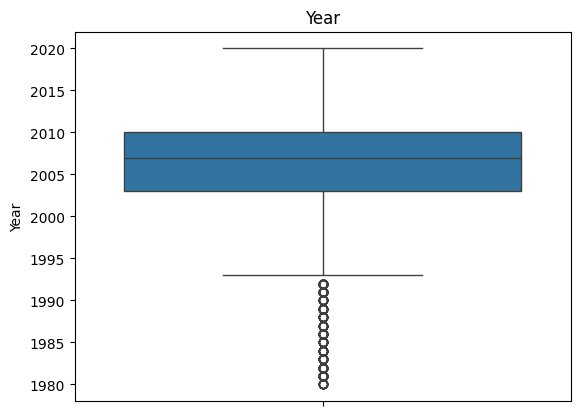

In [1453]:
sns.boxplot(df['Year'])
plt.title('Year')

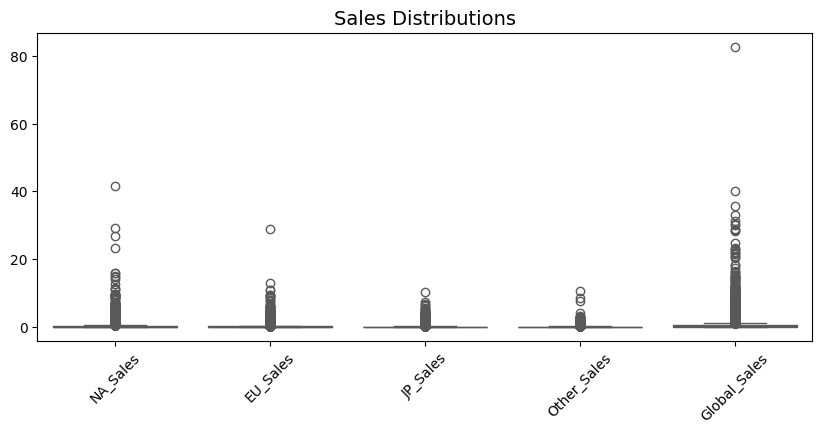

In [1454]:
sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

plt.figure(figsize=(10, 4))
sns.boxplot(data=df[sales], palette="Set2")  # Set2 gives different colors
plt.title("Sales Distributions", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [1455]:
for column in sales:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(column)
    print('outliers count:', outliers.shape[0])
    print(outliers[[column]])
    print("--------------------------------------")

NA_Sales
outliers count: 1681
      NA_Sales
0        41.49
1        29.08
2        15.85
3        15.75
4        11.27
...        ...
2977      0.62
2981      0.63
2995      0.63
3044      0.63
3079      0.62

[1681 rows x 1 columns]
--------------------------------------
EU_Sales
outliers count: 2081
      EU_Sales
0        29.02
1         3.58
2        12.88
3        11.01
4         8.89
...        ...
5463      0.30
5523      0.28
5636      0.28
5643      0.30
5759      0.29

[2081 rows x 1 columns]
--------------------------------------
JP_Sales
outliers count: 2425
       JP_Sales
0          3.77
1          6.81
2          3.79
3          3.28
4         10.22
...         ...
10399      0.11
10405      0.11
10408      0.11
10410      0.11
10412      0.11

[2425 rows x 1 columns]
--------------------------------------
Other_Sales
outliers count: 1665
      Other_Sales
0            8.46
1            0.77
2            3.31
3            2.96
4            1.00
...           ...
7138   

* I kept the outliers because they show real cases of games with very high sales.
* very successful games with high sales.
* These are not mistakes(Noise), but important points that reflect the market.


Dropped Name and Rank:

In [1456]:
df.drop(['Name', 'Rank'], axis=1, inplace=True)

In [1457]:
df.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [1458]:
print(df['Genre'].unique())

['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']


Label encode Genre:

In [1459]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Genre_encoded'] = le.fit_transform(df['Genre'])

In [1460]:
df['Year'] = df['Year'].astype(int)

In [1461]:
print(df['Year'].unique().tolist())

[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994, 1982, 2003, 1986, 2000, 1995, 2016, 1991, 1981, 1987, 1980, 1983, 2020, 2017]


In [1462]:
def classify_y(Year):
    if 1980 <= Year <= 1989:
        return '0'
    elif 1990 <= Year <= 1999:
        return '1'
    elif 2000 <= Year <= 2009:
        return '2'
    elif 2010 <= Year <= 2019:
        return '3'
    elif Year >= 2020:
        return '4'

df['year'] = df['Year'].apply(classify_y)
df.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Genre_encoded,year
0,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,10,2
1,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,4,0
2,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,6,2
3,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,10,2
4,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,7,1


In [1463]:
df.drop('Year', axis=1, inplace=True)

Publisher mean-encoding:

In [1464]:
publisher_sales_mean = df.groupby('Publisher')['Global_Sales'].mean()
df['Publisher_encoded'] = df['Publisher'].map(publisher_sales_mean)
df[['Publisher', 'Publisher_encoded']].head()

,Publisher,Publisher_encoded
0,Nintendo,2.541337
1,Nintendo,2.541337
2,Nintendo,2.541337
3,Nintendo,2.541337
4,Nintendo,2.541337


In [1465]:
df.drop('Publisher', axis=1, inplace=True)

Platform mean-encoding:

In [1466]:
platform_sales_mean = df.groupby('Platform')['Global_Sales'].mean()
df['Platform_encoded'] = df['Platform'].map(platform_sales_mean)
df[['Platform', 'Platform_encoded']].head()

,Platform,Platform_encoded
0,Wii,0.699404
1,NES,2.561939
2,Wii,0.699404
3,Wii,0.699404
4,GB,2.606633


In [1467]:
df.drop('Platform', axis=1, inplace=True)

# Exploratory Data Analysis

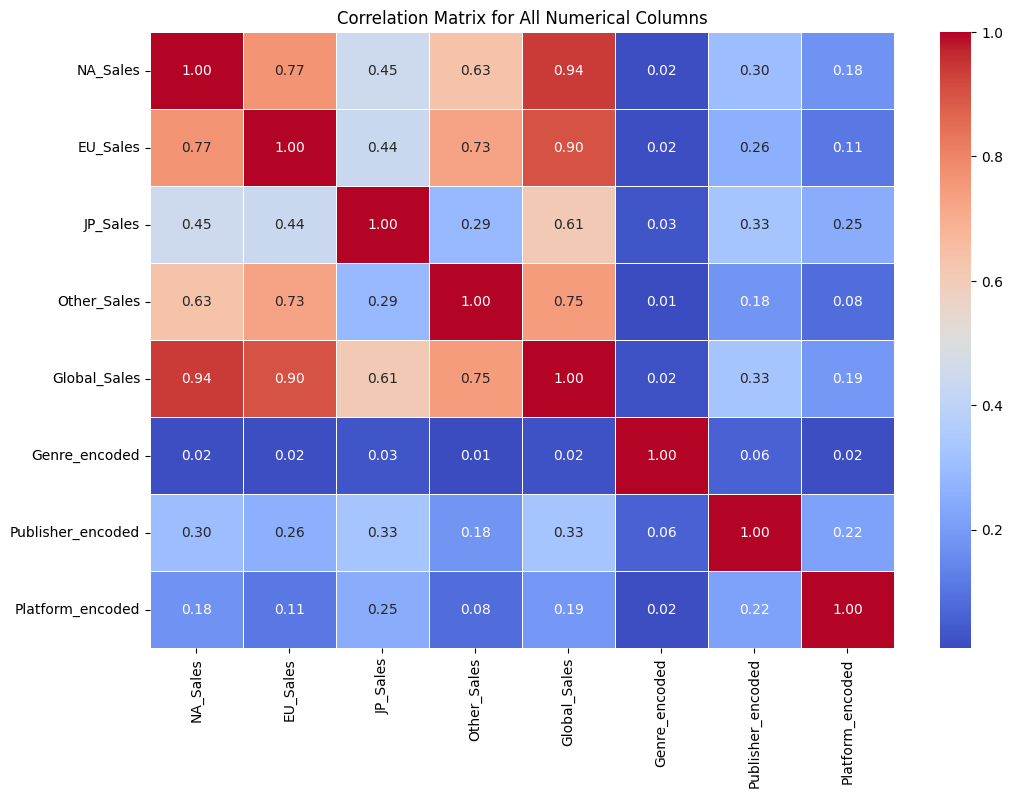

In [1468]:
#The correlation between featuers
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for All Numerical Columns')
plt.show()

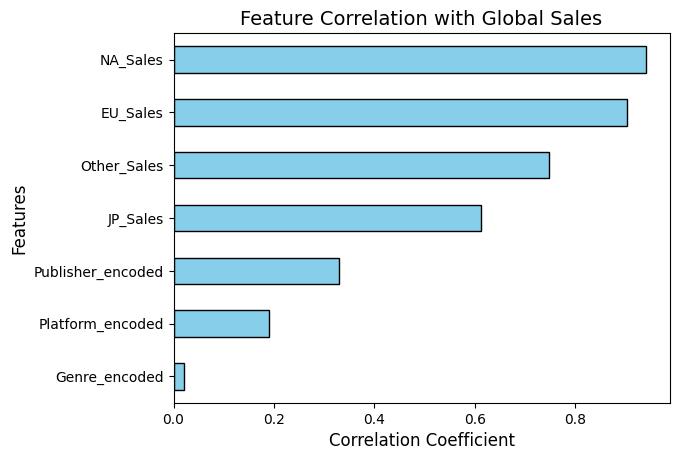

Top features correlated with Global Sales:

NA_Sales             0.941047
EU_Sales             0.902836
Other_Sales          0.748331
JP_Sales             0.611816
Publisher_encoded    0.330341
Platform_encoded     0.190083
Genre_encoded        0.021671
Name: Global_Sales, dtype: float64


In [1469]:
# Most strongly correlated with Globals Sales
correlation_matrix = df.corr(numeric_only=True)
glo_corr = correlation_matrix['Global_Sales'].drop('Global_Sales')
glo_corr_sorted = glo_corr.sort_values(ascending=False)

# plot
glo_corr_sorted.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Feature Correlation with Global Sales", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()  # Strongest correlation at top
plt.show()

print("Top features correlated with Global Sales:\n")
print(glo_corr_sorted)


Scatter / Publisher vs Global Sales:

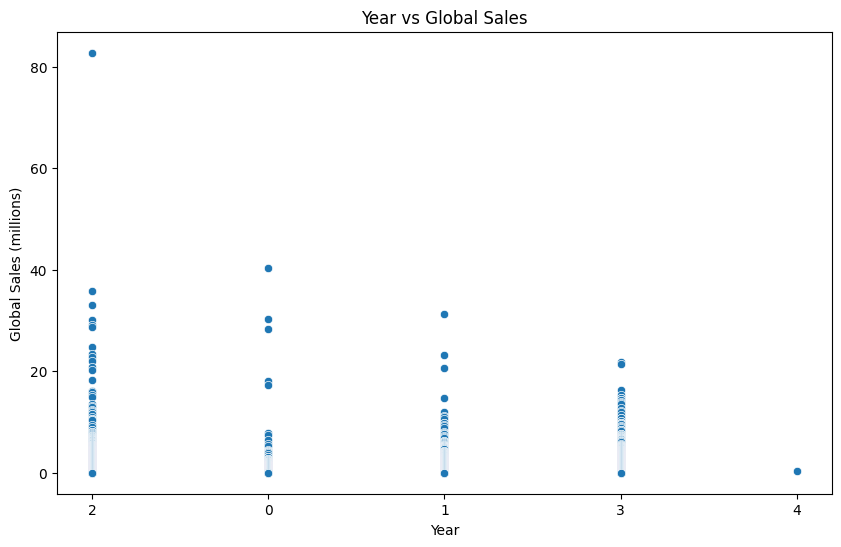

In [1470]:
# Relationship between the year and global sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='Global_Sales', data=df)
plt.title('Year vs Global Sales')
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.show()

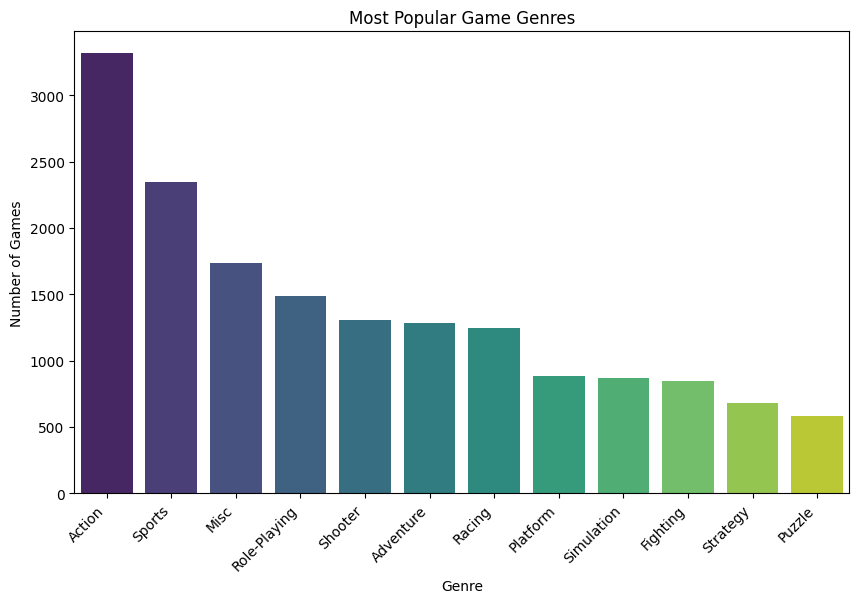

In [1471]:
genre_counts = df['Genre'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Most Popular Game Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.show()

In [1472]:
df.drop('Genre', axis=1, inplace=True)

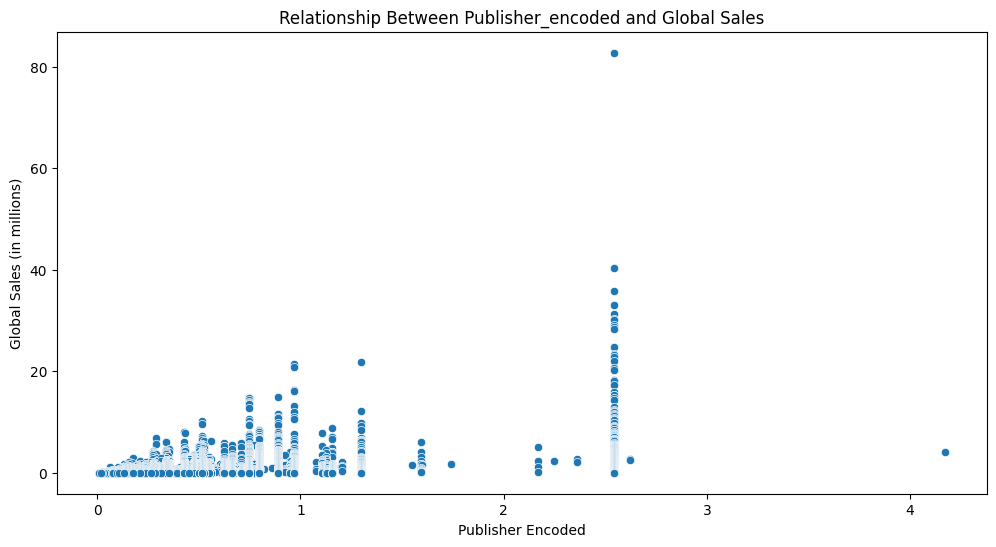

In [1473]:
# The relationship between Publisher and global sales?
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Publisher_encoded', y='Global_Sales')
plt.title('Relationship Between Publisher_encoded and Global Sales')
plt.xlabel('Publisher Encoded')
plt.ylabel('Global Sales (in millions)')
plt.show()

# Multiple Linear Regression

Define predictors & original OLS fit:

In [1474]:
# Define predictors (choose multiple features) and target
X = df.drop(columns=['Global_Sales', 'EU_Sales','JP_Sales', 'Other_Sales'])  # Keep other features
y = df['Global_Sales']

# Convert 'year' column to numeric
X['year'] = pd.to_numeric(X['year'])

# Add constant (intercept term)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary with coefficients, R², p-values, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 2.642e+04
Date:                Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:08:56   Log-Likelihood:                -12681.
No. Observations:               16598   AIC:                         2.537e+04
Df Residuals:                   16592   BIC:                         2.542e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1626      0.01

# Validate assumptions

Residuals vs Fitted:

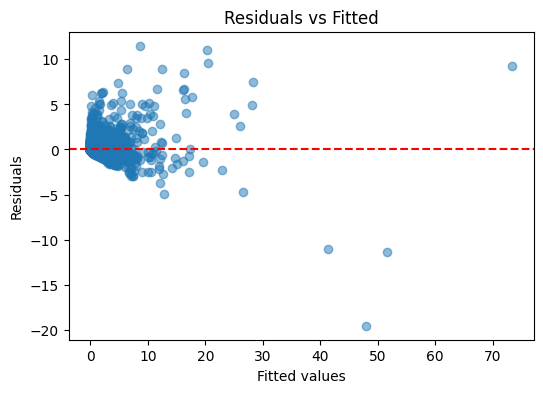

In [1475]:
fitted = model.fittedvalues
resid = model.resid

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

* Residual=Observed value−Predicted value
* A residual is the difference between the observed value and the predicted value from a model


Durbin–Watson:

In [1476]:
print("Durbin–Watson:", round(durbin_watson(resid), 3))

Durbin–Watson: 1.937


Q–Q plot & Shapiro:

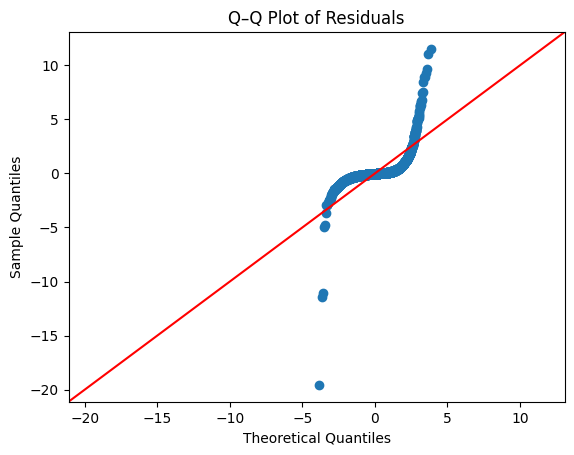

Shapiro–Wilk Test: W=0.446, p-value=0.0000


In [1477]:
# Q-Q plot
sm.qqplot(resid, line="45")
plt.title("Q–Q Plot of Residuals")
plt.show()

# Shapiro–Wilk test
W, p_value = stats.shapiro(resid)
print(f"Shapiro–Wilk Test: W={W:.3f}, p-value={p_value:.4f}")

Correlation heatmap:

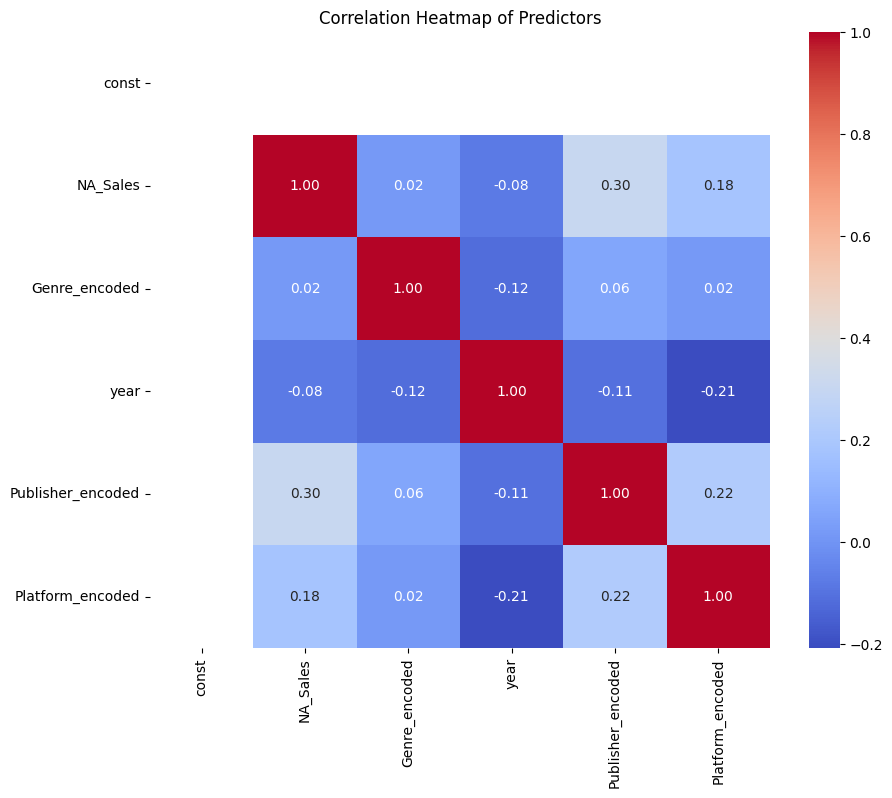

In [1478]:
# Address multicollinearity
corr = X.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Predictors")
plt.show()

VIF table:

In [1479]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

             feature        VIF
0              const  22.209292
4  Publisher_encoded   1.140658
1           NA_Sales   1.118281
5   Platform_encoded   1.104171
3               year   1.064578
2      Genre_encoded   1.016683


## Address non-linearity and heteroscedasticity



Log transform of sales:

In [1480]:
sales_columns = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
for col in sales_columns:
    df[f'Log_{col}'] = np.log(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.drop(columns=sales_columns, inplace=True)
df = df.dropna()
df.head()

,Genre_encoded,year,Publisher_encoded,Platform_encoded,Log_Global_Sales,Log_NA_Sales,Log_EU_Sales,Log_JP_Sales,Log_Other_Sales
0,10,2,2.541337,0.699404,4.415703,3.725452,3.367985,1.327075,2.135349
1,4,0,2.541337,2.561939,3.694862,3.370051,1.275363,1.918392,-0.261365
2,6,2,2.541337,0.699404,3.578506,2.763170,2.555676,1.332366,1.196948
3,10,2,2.541337,0.699404,3.496508,2.756840,2.398804,1.187843,1.085189
4,7,1,2.541337,2.606633,3.445852,2.422144,2.184927,2.324347,0.000000


Log-target OLS fit (model_log) & summary:

In [1481]:
df_log = df.dropna()

X = df_log.drop(columns=['Log_Global_Sales', 'Log_EU_Sales',  'Log_Other_Sales','Log_JP_Sales',], errors='ignore') #
y = df_log['Log_Global_Sales']

X = sm.add_constant(X)

if X['year'].dtype == 'object':
    X['year'] = pd.to_numeric(X['year'])

model_log = sm.OLS(y, X).fit()
resid_log = model_log.resid

# Show summary with coefficients, R², p-values, etc.
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Log_Global_Sales   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2111.
Date:                Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:08:57   Log-Likelihood:                -1673.2
No. Observations:                2378   AIC:                             3358.
Df Residuals:                    2372   BIC:                             3393.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7115      0.05

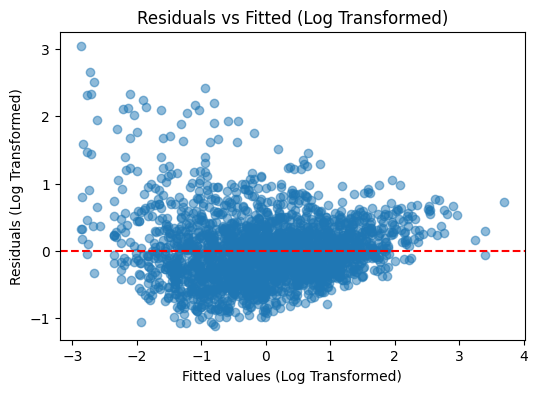

In [1482]:
# The fitted values against the residuals from the re-fitted model
fitted_log = model_log.fittedvalues
plt.figure(figsize=(6,4))
plt.scatter(fitted_log, resid_log, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values (Log Transformed)")
plt.ylabel("Residuals (Log Transformed)")
plt.title("Residuals vs Fitted (Log Transformed)")
plt.show()

In [1483]:
from statsmodels.stats.stattools import durbin_watson

print("Durbin–Watson:", round(durbin_watson(resid_log), 3))

Durbin–Watson: 1.671


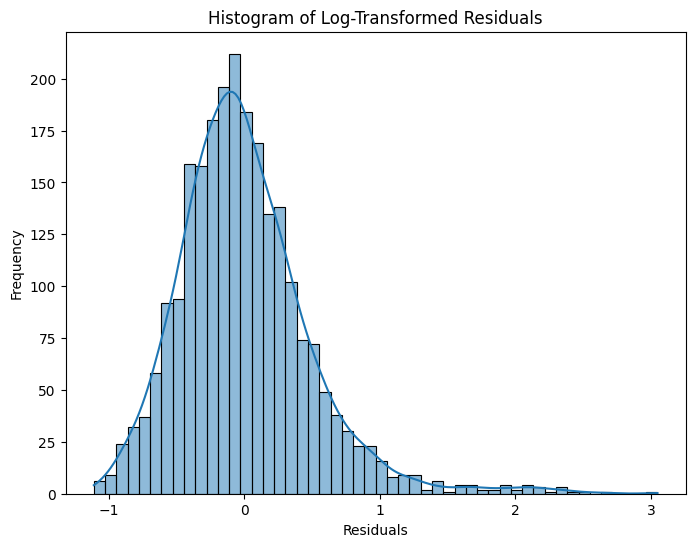

In [1484]:
# Histogram of the residuals
plt.figure(figsize=(8, 6))
sns.histplot(resid_log, kde=True)
plt.title('Histogram of Log-Transformed Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

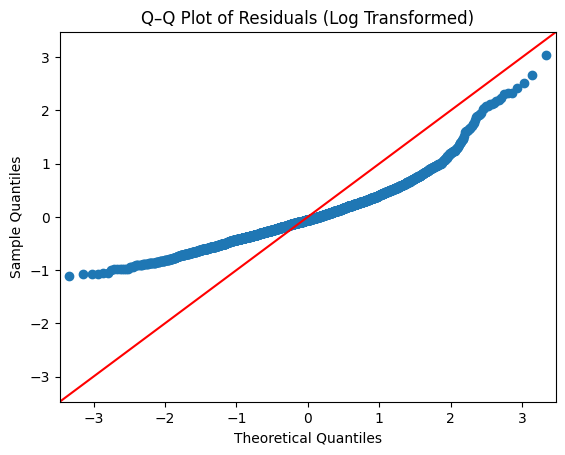

Shapiro–Wilk Test: W=0.446, p-value=0.0000


In [1485]:
# Q-Q plot
sm.qqplot(resid_log, line="45")
plt.title("Q–Q Plot of Residuals (Log Transformed)")
plt.show()

# Shapiro–Wilk test
W, p_value = stats.shapiro(resid)
print(f"Shapiro–Wilk Test: W={W:.3f}, p-value={p_value:.4f}")


## Assumption Check for Robust Linear Model (Log-Transformed Data)

- **Independence of Errors**:  Met (Durbin-Watson ≈ 2)  
- **Linearity**:  Met (residuals randomly scattered around zero)  
- **Homoscedasticity**:  Met (variance of residuals looks constant)  
- **Normality**:  Not met (Q-Q plot looks fine, but Shapiro-Wilk p < 0.05)  
- **Multicollinearity**:  Met (after dropping `'EU_Sales', 'JP_Sales', 'Other_Sales'`, VIF < 5)  

**Summary**: Most assumptions are satisfied, except normality of residuals.

## Evaluate robust model performance

- Outliers were kept because they reflect real cases of very successful games with high sales.  
- Robust regression reduces their impact and handles heteroscedasticity.  
- Shapiro-Wilk test indicates residuals are not perfectly normal, even after log transformation.  
- Despite this, the model is suitable for the dataset and produces meaningful results.  
- Strict MLR assumptions are not fully met, but the model remains practically useful.


## Perform sample prediction


In [1522]:
# Select a random row
sample_index = np.random.randint(0, len(df_log))
sample_row = df_log.iloc[sample_index]

print("\nOriginal Log-Global Sales:", sample_row['Log_Global_Sales'])
print("Original Global Sales:", np.exp(sample_row['Log_Global_Sales'])) # Transform back

# Define predictor columns
predictor_columns_to_use = ['Genre_encoded', 'year', 'Publisher_encoded', 'Platform_encoded', 'Log_NA_Sales']

# Create dictionary of predictor values
sample_data_values = sample_row[predictor_columns_to_use].to_dict()

# Create DataFrame
sample_features_df = pd.DataFrame([sample_data_values])

# Ensure 'year' is numeric
sample_features_df['year'] = pd.to_numeric(sample_features_df['year'])

# Add constant
sample_features_df = sm.add_constant(sample_features_df, has_constant='add')

# Ensure column order matches model
expected_column_order = model_log.params.index.tolist()
sample_features_df = sample_features_df.reindex(columns=expected_column_order, fill_value=0)

# Predict log and original sales
pred_log = model_log.predict(sample_features_df)
pred_original = np.exp(pred_log.values[0]) # Get scalar value

print("\nInput Features for Prediction:")
display(sample_features_df)
print("Predicted Log-Global Sales:", pred_log.values[0])
print("Predicted Global Sales:", pred_original)


Original Log-Global Sales: -0.4942963218147801
Original Global Sales: 0.61

Input Features for Prediction:


,const,Genre_encoded,year,Publisher_encoded,Platform_encoded,Log_NA_Sales
0,1.0,8,3,0.798581,0.827679,-1.560648


Predicted Log-Global Sales: -0.43733214258200603
Predicted Global Sales: 0.6457569124189116


In [1523]:
# Sample input data
new_data = pd.DataFrame({
    "Genre_encoded": [10],
    "year": [2],
    "Publisher_encoded": [2.541337],
    "Platform_encoded": [0.699404],
    "Log_NA_Sales": [3.367985]
})

# Add constant and make 'year' numeric
new_data = sm.add_constant(new_data, has_constant='add')
new_data['year'] = pd.to_numeric(new_data['year'], errors='coerce')

# Align columns with model
new_data = new_data[X.columns]

# Predict log and original Global Sales
pred_log = model_log.predict(new_data)
pred_original = np.exp(pred_log)

print("Input Features:")
display(new_data)
print("Predicted Log-Global Sales:", pred_log.values[0])
print("Predicted Global Sales:", pred_original.values[0])


Input Features:


,const,Genre_encoded,year,Publisher_encoded,Platform_encoded,Log_NA_Sales
0,1.0,10,2,2.541337,0.699404,3.367985


Predicted Log-Global Sales: 3.4186384075573653
Predicted Global Sales: 30.52782026056371


## Save the MLR model


Save model to joblib:

In [1525]:
import joblib

filename = 'global_sales_model.joblib'
joblib.dump(model_log, filename)
print(f"Model saved as {filename}")

Model saved as global_sales_model.joblib
